In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

391 genes excluded.


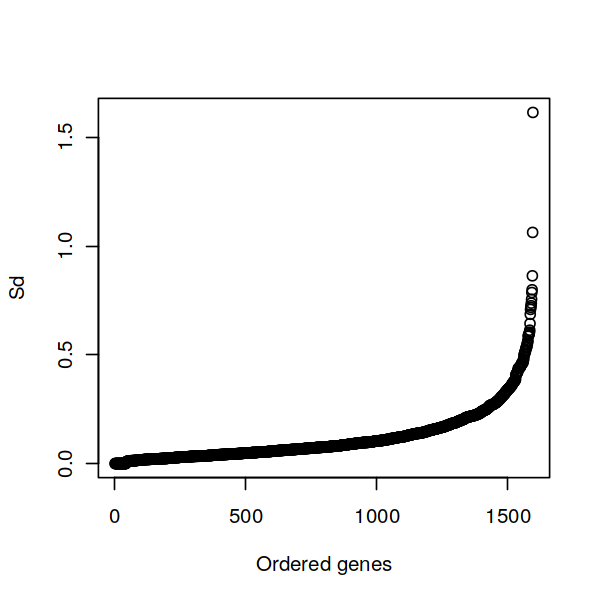

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-ABM-aLP1_5to1-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

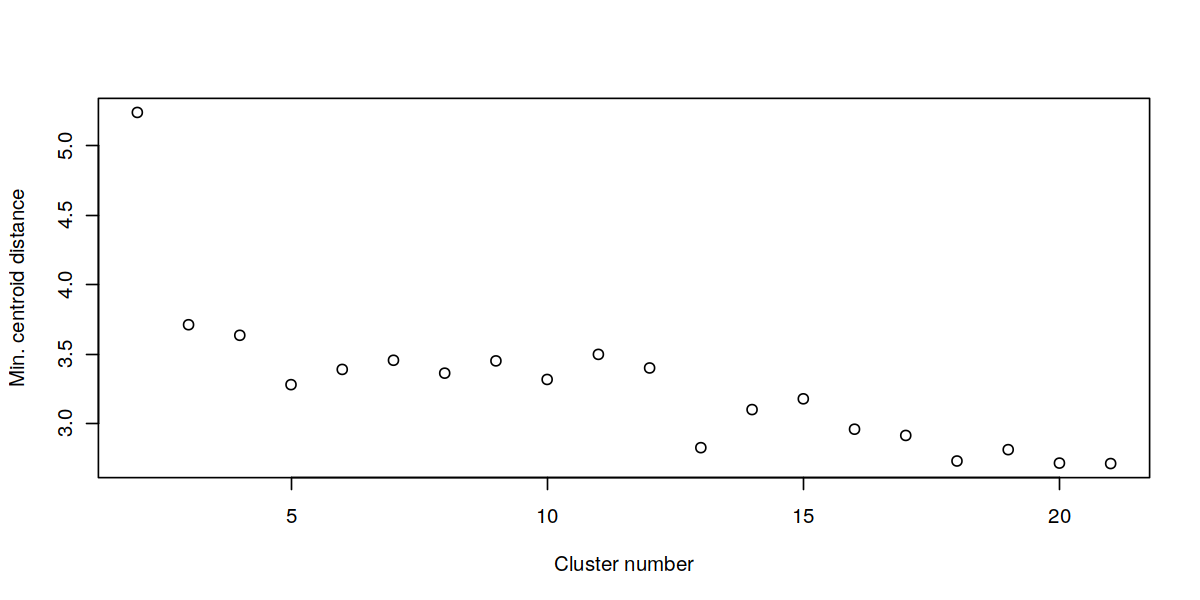

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


Warning message:
“Ignoring unknown aesthetics: order”


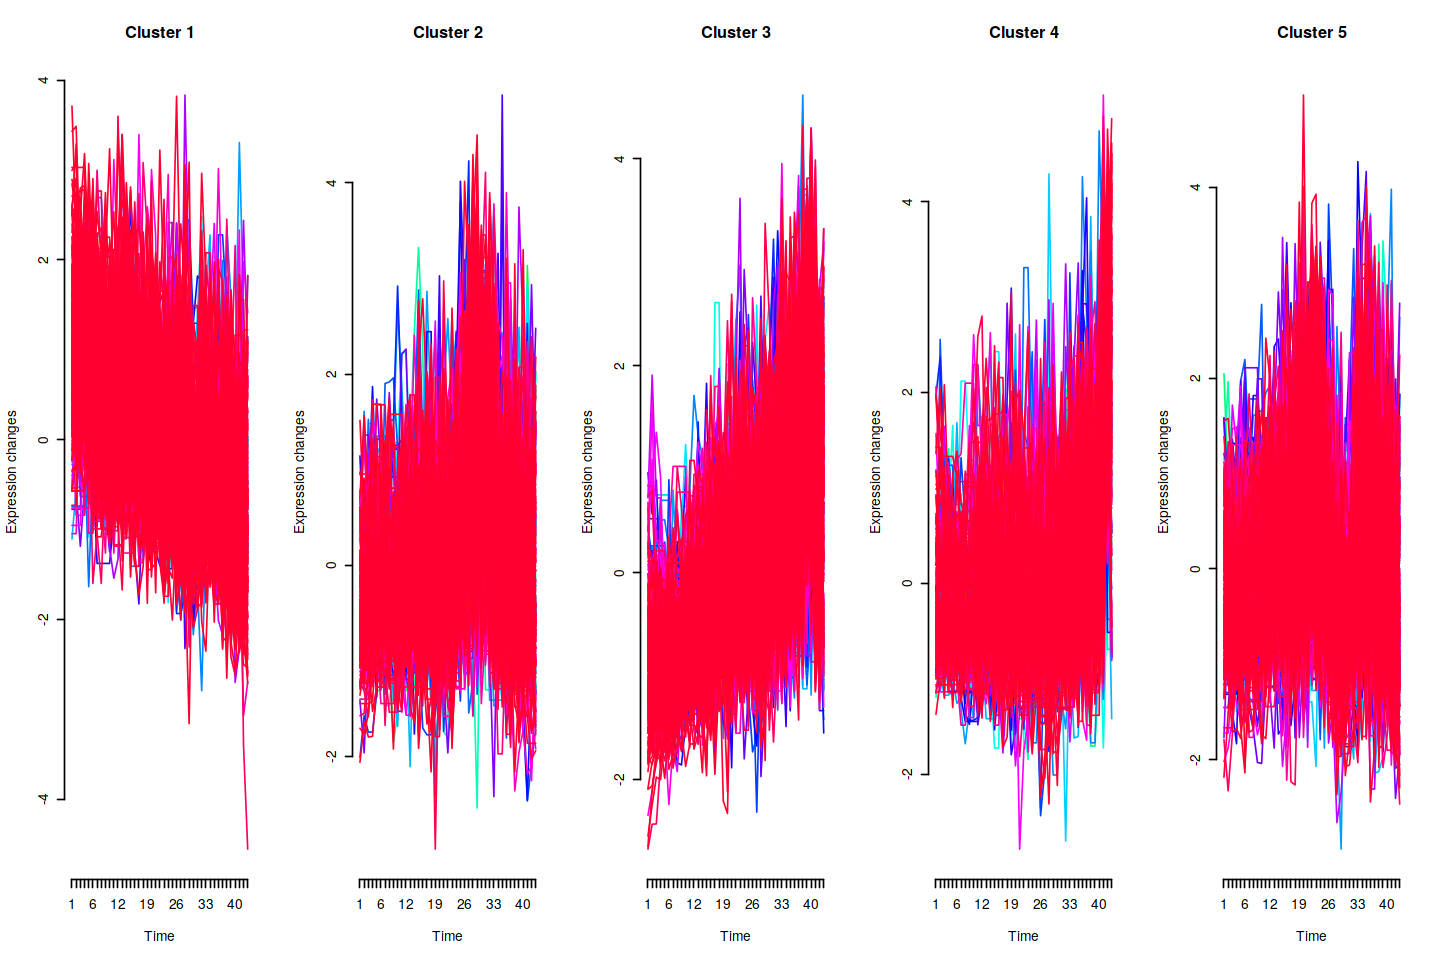

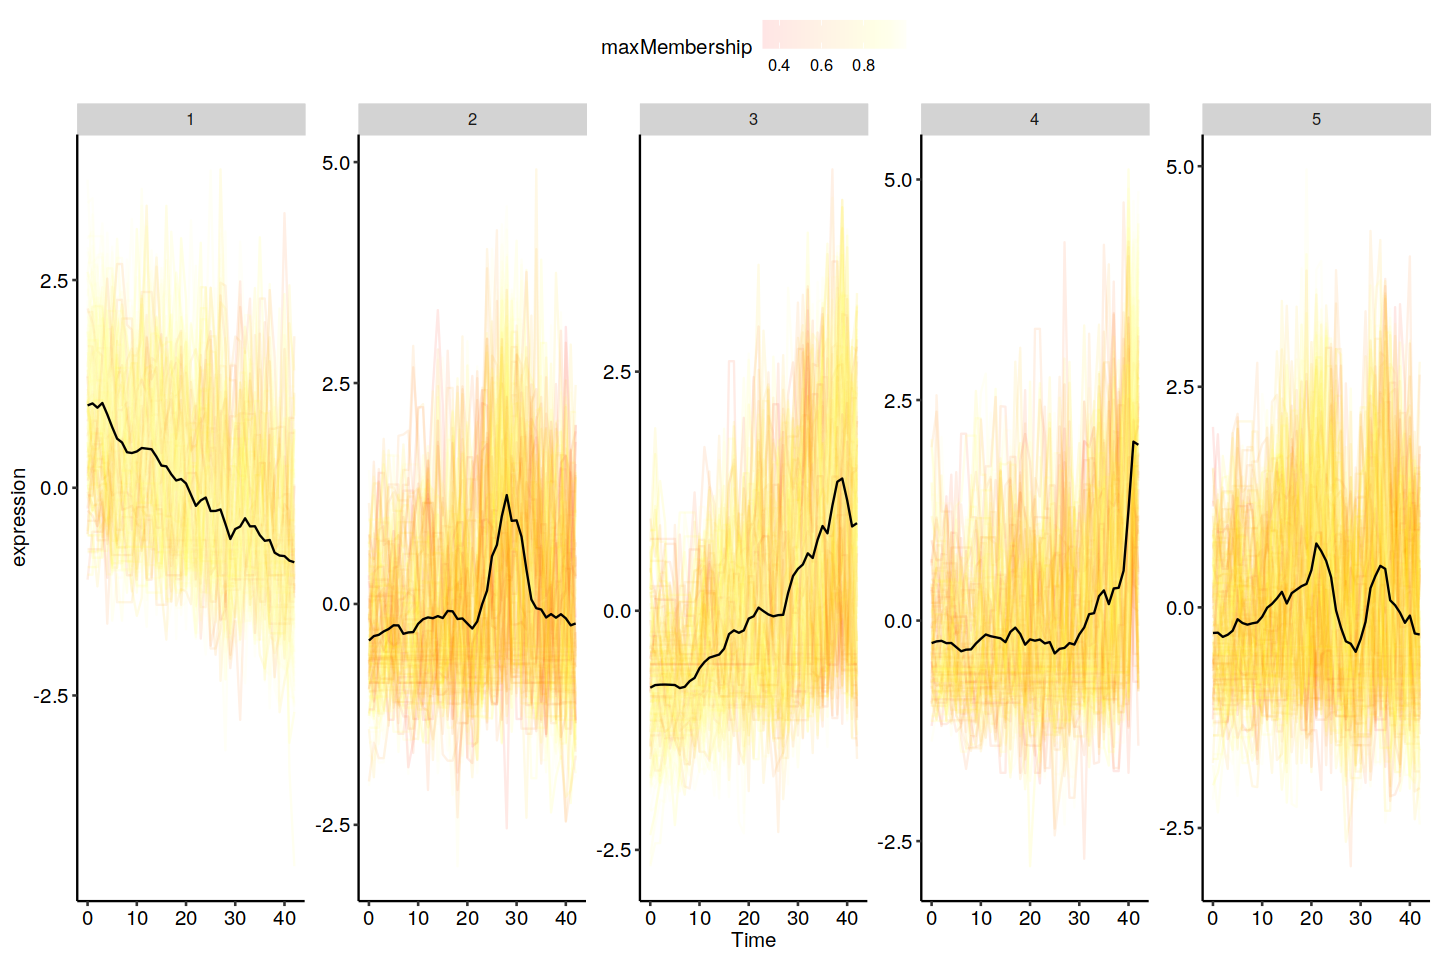

In [7]:
# 3. do clustering and show
c <- 5 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(1,5), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=1,ncol=5)

In [8]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 243 206 311 204 240

In [9]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [10]:
res1 <- path.enrichment.analysis(1)
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.68% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“8.62% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.26% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.65% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“7.73% of input gene

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


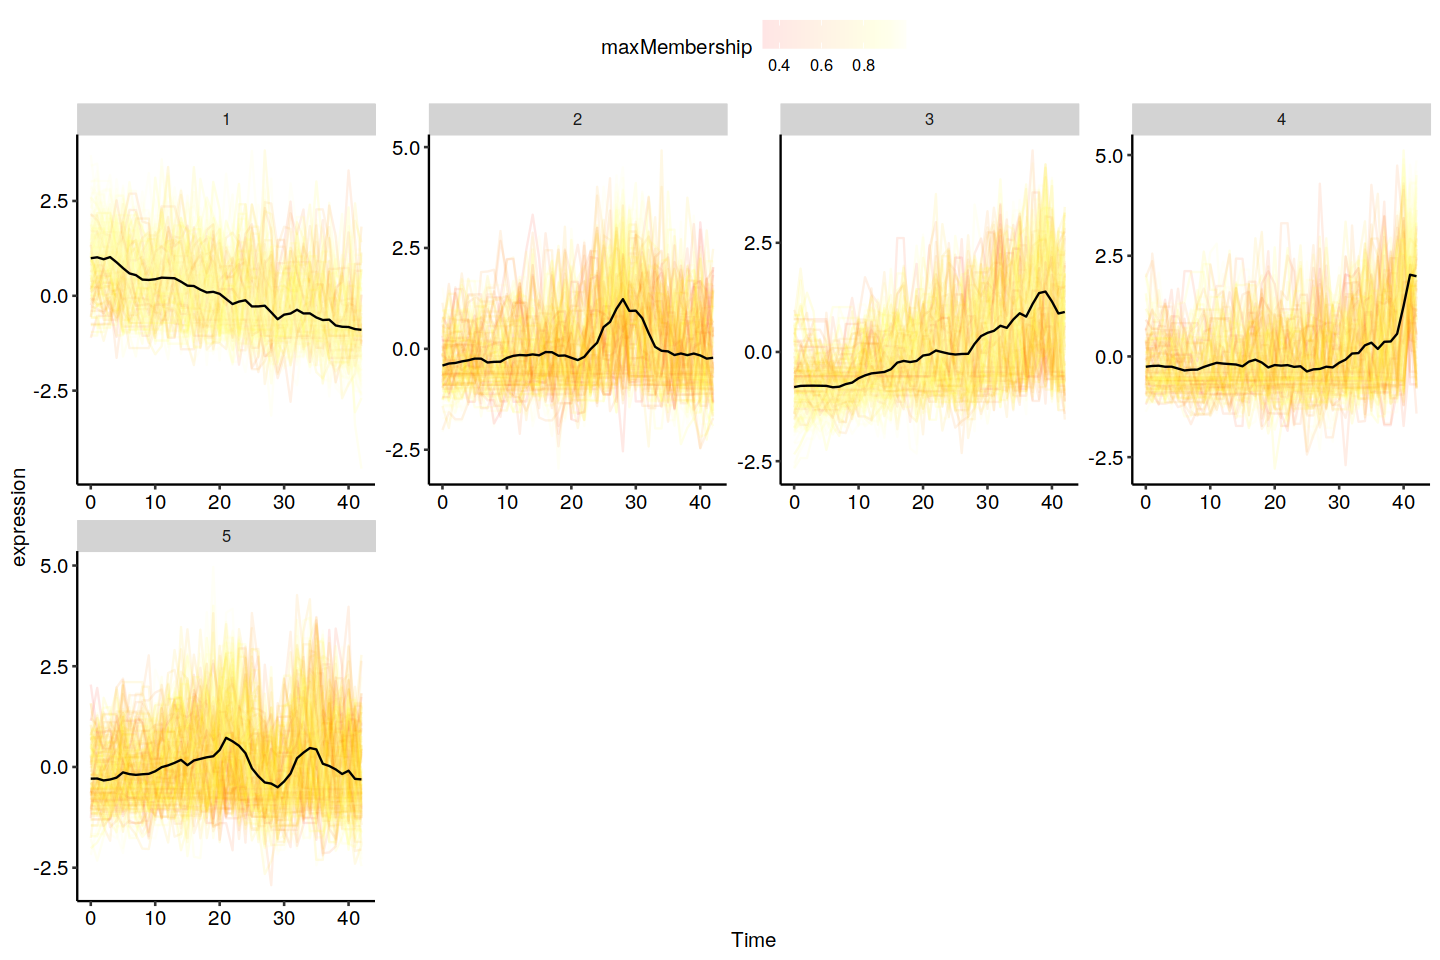

In [11]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

## C1

[1] "Genes:"
Serpinb1a Emb Tuba1b Cd81 Lyz2 Cd34 Ctla2a Egfl7 Tuba4a Tubb5 Ifitm3 Myc Ncl H2afy Ccnd2 Ifitm2 Ranbp1 Rrm2 Pcna Dut Syce2 Mpo Mif Prtn3 Rpa2 Cdk6 Smc2 Mcm6 Ezh2 Lig1 Dntt Ung Nkg7 Cdk1 Tipin Ran Stmn1 Fabp5 Mcm7 Igfbp4 Cdca7 Gcnt2 Ctr9 Tk1 Cd24a Mcm2 Glipr1 Uhrf1 Marcksl1 Il12a Myl10 Cd27 Rrm1 Hmga2 Cdkn1a Tyms Mcm3 Top2a Ncf4 Acot1 Mcm5 Ccne2 Hells Gmnn Basp1 Pclaf Snx14 Usp37 Dhfr Dusp2 Lmo2 Tmem38a C730034F03Rik Ar Clspn Spc24 Tspan32 Hmgb3 Tmem108 Ifi27 Serpina3g Tmpo Rhob Gm26802 Izumo4 Pbk Hk2 Serpinf1 Tmem176b Smc4 Ptpre Itga4 Gpr65 Anp32b Srm Tcf19 Cnn3 Pim1 Ass1 Samsn1 Shisa8 Tifa Dtl Cycs Ebf1 Arl6ip1 Cdv3 Cks2 Ldha Fam105a Tox Paip2b Pou2f2 Gm26917 Plk4 Kdm5b Lgals3bp Lmnb1 Sox4 Rtp4 Tubb4b Gimap6 Asf1b Chd3 Ifitm1 Gm11579 Ifi203 Nasp Arid5b Arhgef3 Incenp Hspa1a Tnni1 AA467197 Cd69 Il18rap Pola2 Aldoa Wfdc17 Lgals9 Oaf Tacc3 Gm49359 Sgms1 Gprc5b Klf3 Xrcc6 Mcm4 Hcst Lax1 Parvb Trf Alox5 Cd6 Gm47283 Bfsp2 Ms4a6b Paip1 5830416I19Rik Fam117b Ccl3 Ckap2l Apaf1 Ata

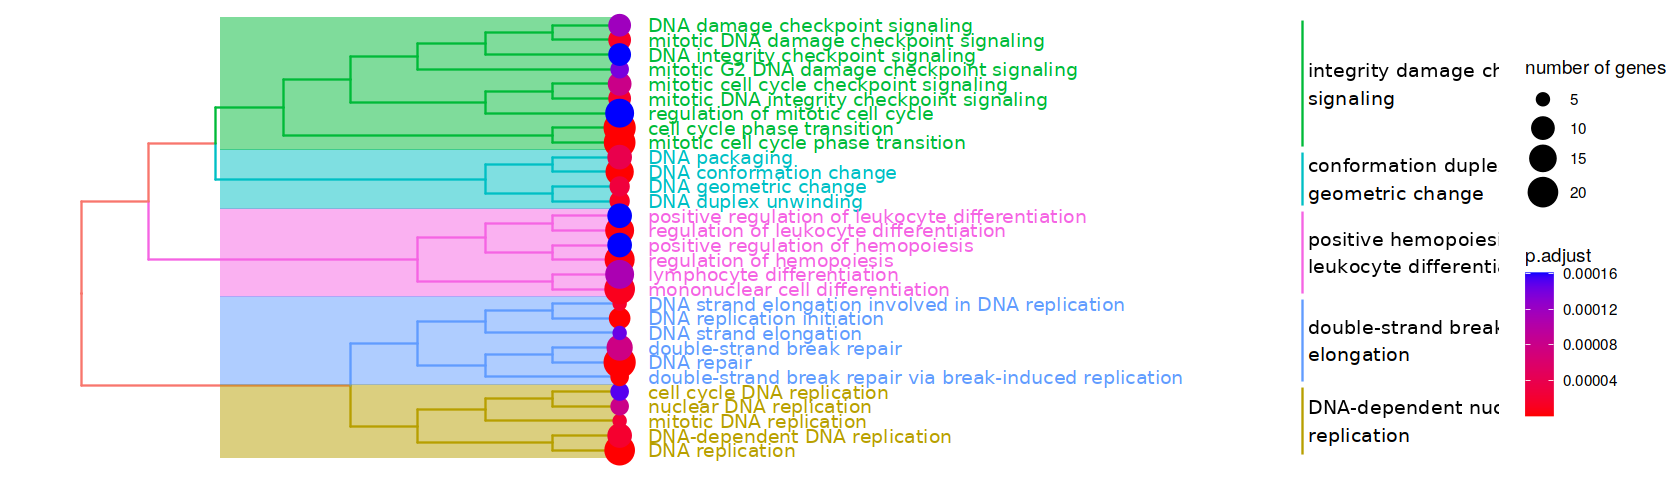

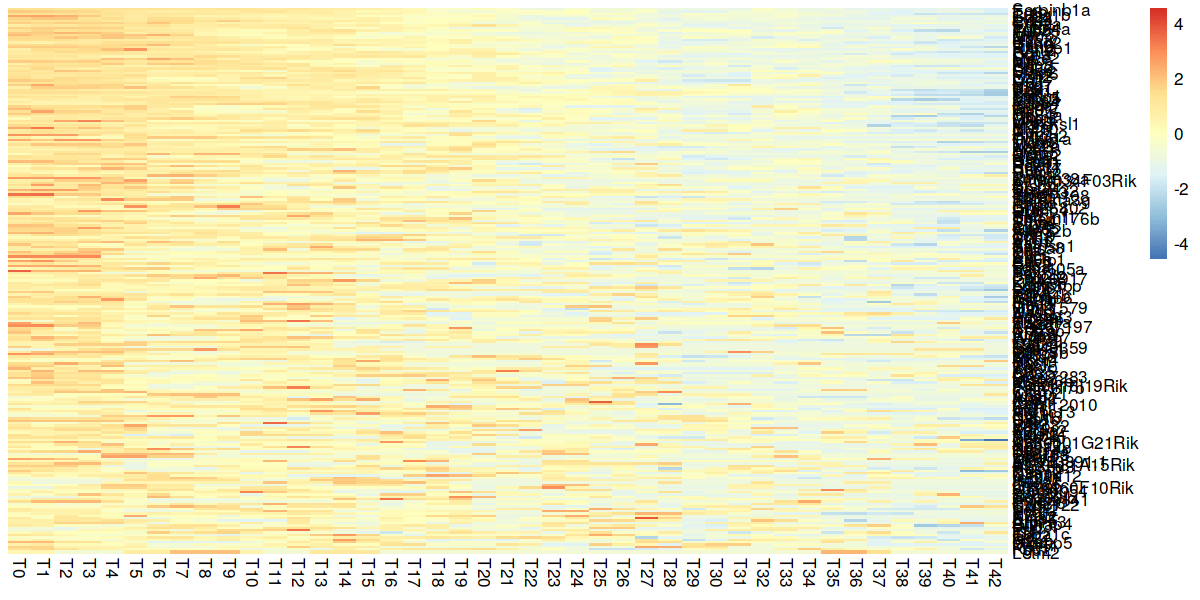

In [13]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C2

[1] "Genes:"
Hist1h2bc Spp1 Cenpf Hist1h1c Cenpe Ccnb2 Clec2i Cdca3 Birc5 Hist1h4i Cenpa Nek2 Anp32e Cdca8 Ngp Cmpk2 Bambi Lockd BC022687 Snhg20 1700097N02Rik Hmgn2 Cd9 Wnt10b Socs1 Cnp Grasp Dclre1c Psrc1 Nucks1 Lmo4 Anxa2 Gcfc2 Vim Rnf122 Tmem140 Amz1 Ccnd3 Myh9 Aplp2 Marcks Arhgef11 Hist1h2ae Bicd1 Cdc20 Fcgr2b Mis18bp1 Nde1 Wfs1 Carhsp1 1500009L16Rik Cdkn3 2310001H17Rik Mmp15 H1fx Tspyl2 S100a9 Gadd45a Hmmr H2-Q7 Racgap1 2810454H06Rik Gata3 Hist1h2ac Gm5914 Lgals3 Hmgb2 Gfi1b Aph1c Xpr1 Exoc1 Ptms Usp18 Tcp11l2 Gm47754 Cited2 Ppp1r16b Hdc Kif11 Klf13 Slc7a7 Mki67 Gpr146 Slfn8 H2-K1 Cd3g Uso1 Fstl3 Sh2d3c Tnfrsf13c Clec10a Serpinb6b Tmem119 Stk17b Mir142hg Dusp22 Clec12a Tsc22d1 Hist2h2be Antxr2 Nfkb1 Ddit4 Ifih1 Jak2 Ttf1 Gbp9 Pglyrp1 Ppp1r15a Ccnb1 Tpx2 Osbpl7 Hist1h1e Lpgat1 Tmem71 Snx32 Fcgr3 Paqr7 Myo1c 5031425E22Rik Tmem50b Gm47438 Csrp3 Tmsb15b1 Lat Kif21b Rhoh H2afv Grap2 D830025C05Rik Inafm2 Sapcd1 Setd4 Sp140 Dok3 Acadm Tpm2 Shisa2 Cd82 S100a8 Cd2 Gpr34 Yae1d1 Bbs4 Lyn Gm1

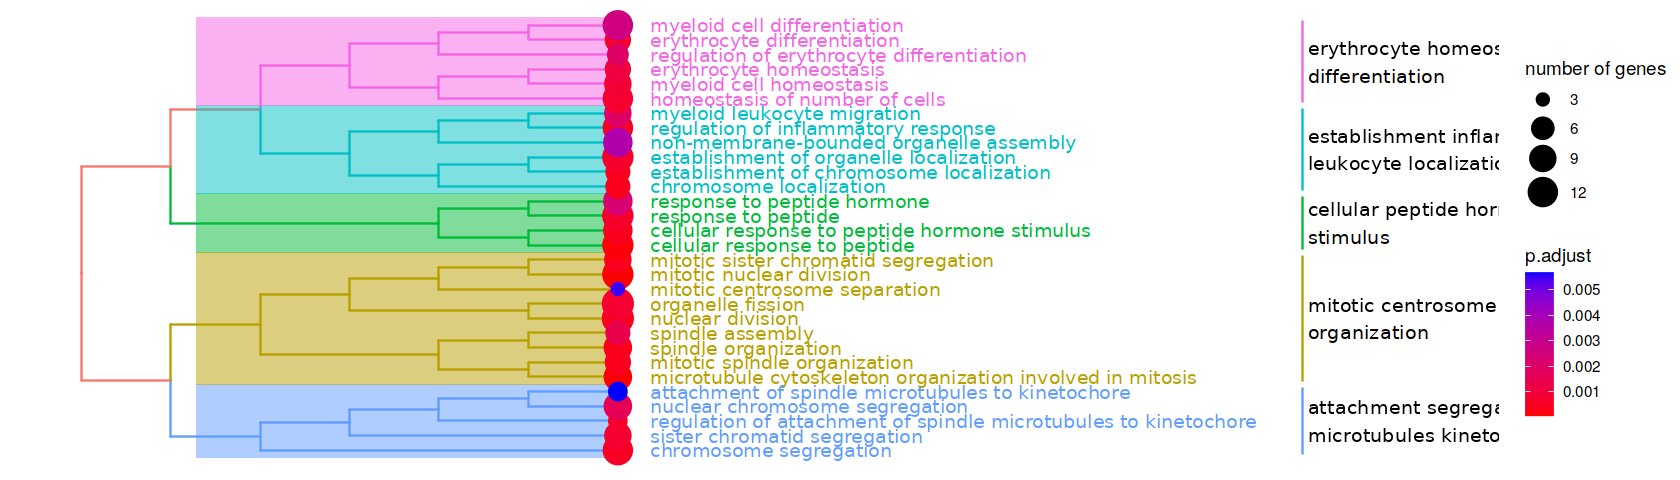

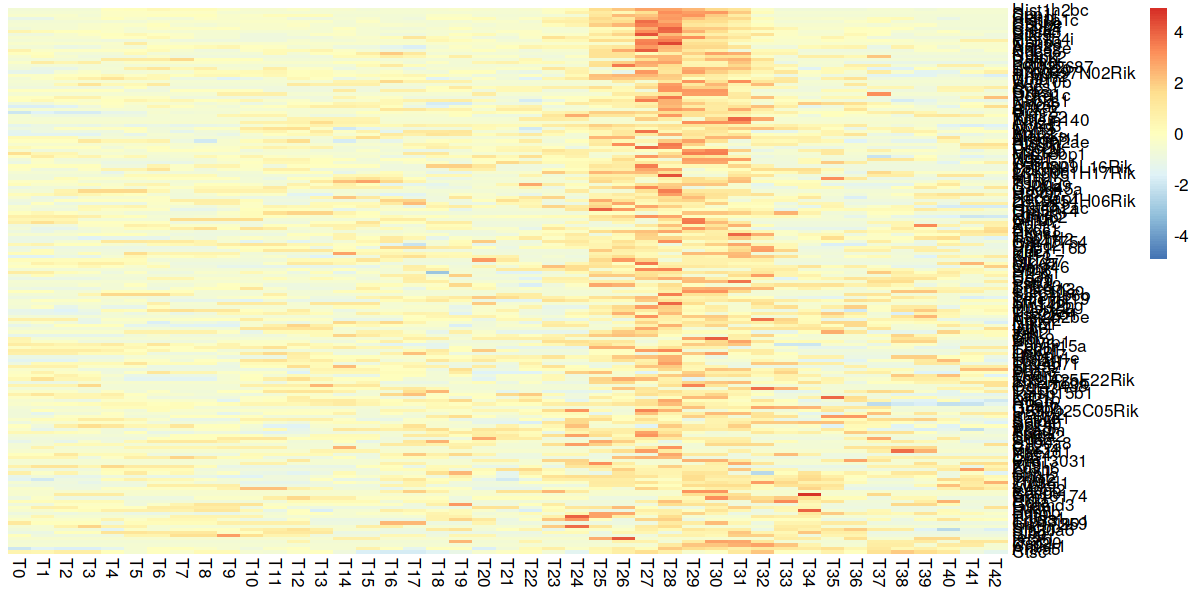

In [14]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C3

[1] "Genes:"
Cd7 Psap Bst2 Rnase6 Ctsb Dnajc7 Selplg Siglech Tex2 Lsp1 Grn Tyrobp Ly6c2 Nucb2 Smim5 Pacsin1 Ctsh Ctsz Cox6a2 Sdc4 Jaml Ctss Cybb Blk Ly6d Atp1b1 Spib Prdx5 Xbp1 Rexo2 Ly6e Sp100 Sell Selenos H2-T23 Serp1 S100a6 Fcer1g Galnt12 Kmo Fgr Anxa6 Irf8 Prr13 Pld4 Cd300c Klf2 Stoml1 Cyth4 Sema4b Tubgcp5 Unc93b1 Hmgcs1 Sdc1 Fyb Them6 Hspa5 Abhd17b Tspan13 Slamf6 Lefty1 Btg1 Hs3st1 Herpud1 Cd3d Tnfrsf13b Scpep1 Atp1a3 Dirc2 Clcn5 Klrd1 Itgb2 Hvcn1 Gas7 Net1 Upb1 Tubb2a Capg Ctsl Kctd12 Prss34 Cyba Slc44a2 Slc8b1 Sec24d Rab6b Ctsa Inpp4a Gns Tbc1d8 Tpd52 Irf5 Slc37a2 Ypel3 Slpi Itm2c Pkp3 Gsn Card11 Ier5 Vsir Ifi27l2a Tmed3 Sh3tc1 Csf2rb2 Rhbdf2 Blvrb Scimp Nek6 St3gal6 Tcf4 Plek Stat2 Nrp1 Carmil1 Rassf4 Fth1 Inf2 Gbp8 Pira2 Ptprc Rab33b Adora2a Gadd45b Epha2 Tmem221 Bcl11a Slc29a3 Tapbp Fcrla Mvb12a Stat1 Ifnar1 Stx7 Ppfia4 Themis2 S100a4 4833407H14Rik Hist3h2ba Bcl3 Serinc5 H2-D1 1110008P14Rik Traf1 Ubl3 Fbxl13 Lifr Ptprf Padi1 Ly86 Sla2 Tgfbr1 Cst3 Rsrp1 Pkig Plp2 Rasgrp4 Dnajc

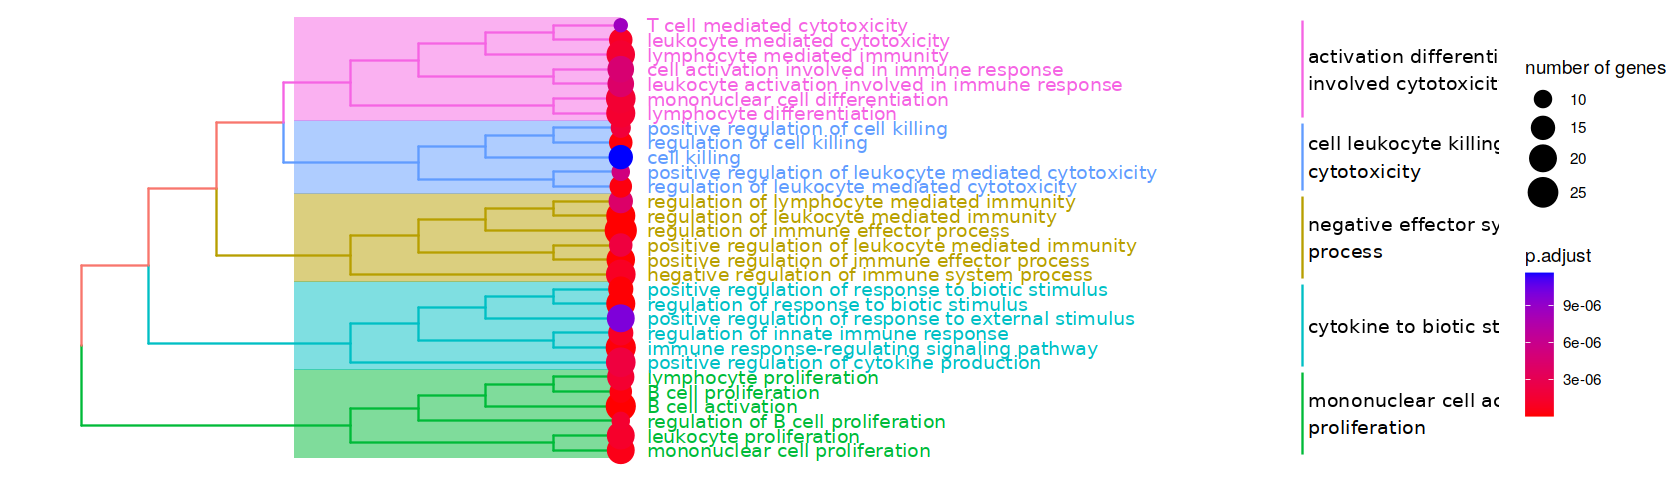

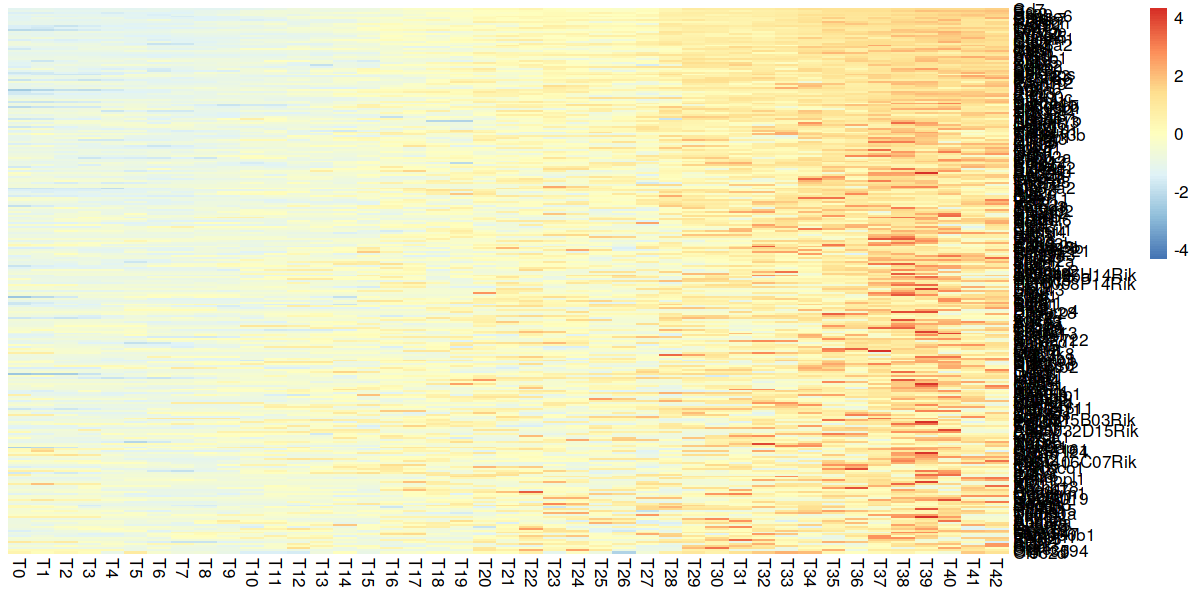

In [15]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Gm39091 Isg15 Pltp Gem Kcnk10 Cd200 Tmem163 Nsg2 Mfhas1 Cib2 Prkcb St8sia4 H2-Ab1 Ak8 Cd8a Ppm1l Klk1 Mospd2 Cd74 Slc2a3 Gab3 Ccr9 Hbb-bs Sh3bgr Pkib Slc15a3 Emilin2 Acsl1 Vav2 Skap1 Runx2 Havcr1 Tubb2b Mgl2 Kdm6b Maf Ciita Orai2 Cd68 3830403N18Rik Acp5 2310035C23Rik Rnd3 Cd300lf Rnasel Tep1 H2-Aa H2-DMb1 Cd63 P2ry14 Timp2 Grap Cd209a Icam1 Arhgap27os2 Pdcd4 Grina D730003I15Rik Mid1ip1 Fam174a Eepd1 Sat1 Itgax Stard5 Ccl5 Ptprs Znfx1 Ddr1 Pqlc3 Ccnd1 Hck Cd84 Cyp27a1 Reep4 Parp3 Pim2 Fcmr Epsti1 Oasl1 Trim12c Khk BC147527 Slc46a3 Msh5 Fdps Abhd14b Slfn2 Plxnc1 Nlrc3 Pdia5 Cyp4f18 Gata2 Prkx Ifnar2 Kynu Camp Igf1r Bhlhe40 Maml2 Tmem63a Zeb2 Tiparp Fgfr1 Rab19 Npc1 B3galnt1 Crebrf Lag3 4732496C06Rik Tnfaip8l2 Klf6 Atp2a1 Trbc1 Mob3c Trib1 Cpne2 Hebp1 Ppm1h Ldlr Zdhhc14 Eps15 Il18 Cfp Rubcn Zcchc24 Klhdc1 Fam69a Ccdc180 Srebf2 Oasl2 Pik3ap1 Zfp85 Plxdc2 Foxr1 Calr Fbxl17 Ctnnd2 Jpt1 Acbd4 Dopey2 Ldlrad3 Trim30d Mindy2 Adgre5 Id1 Wsb2 Agpat3 Slc39a1 Dhx58 Prkca Pdgfa Trim5 Rel

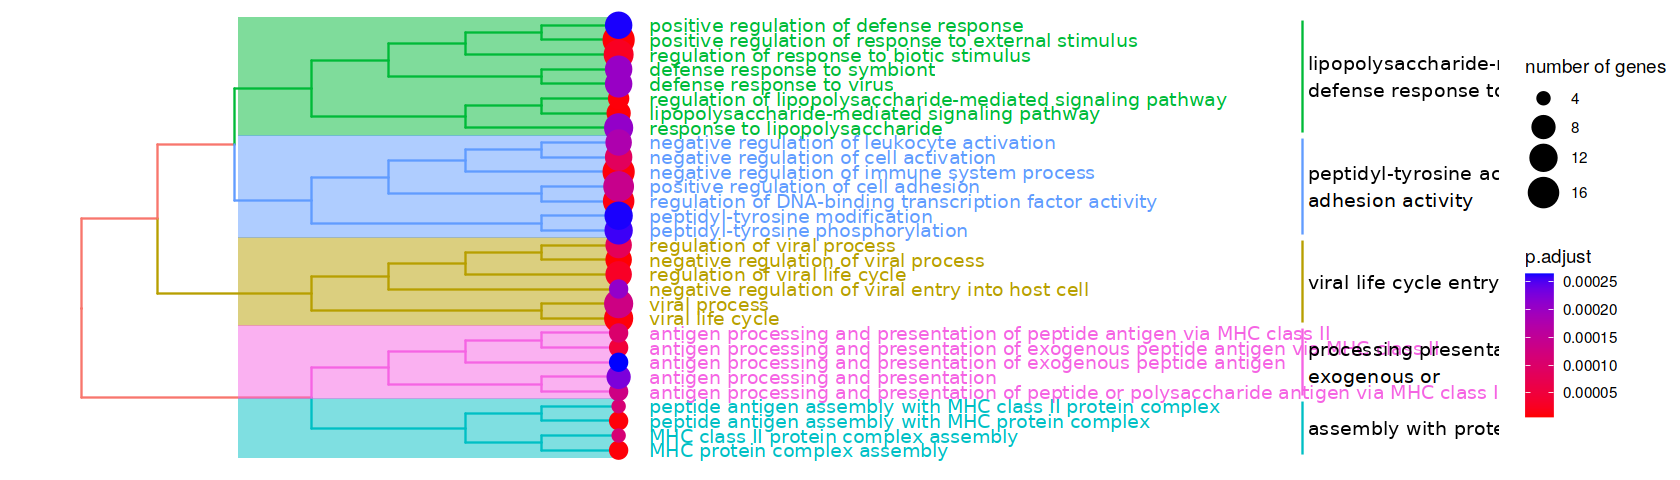

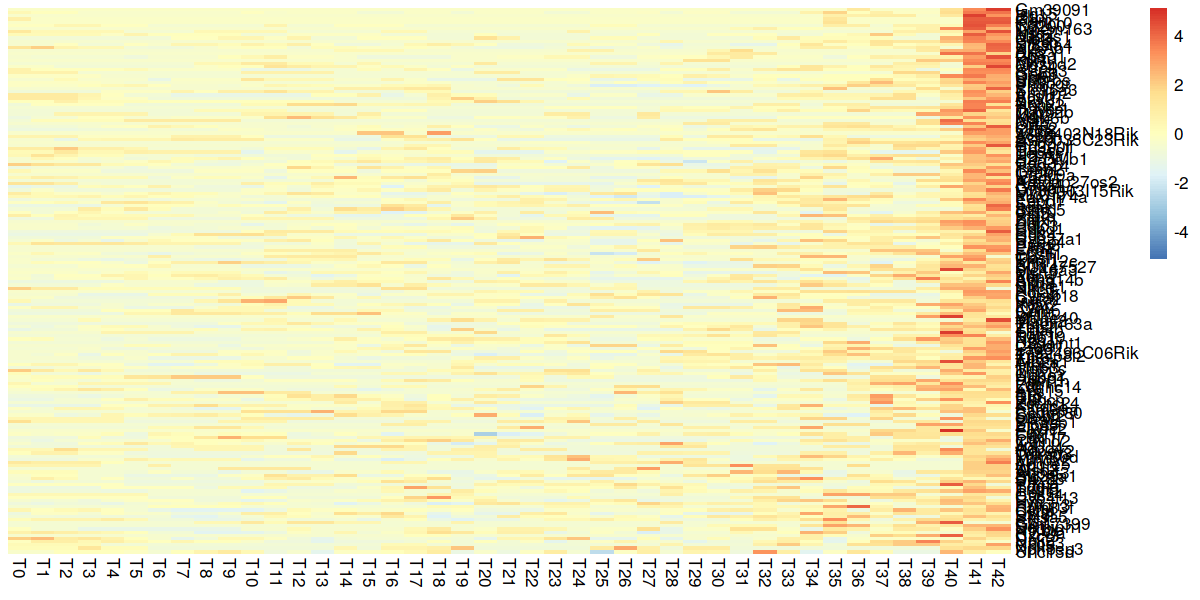

In [16]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Hes6 Pycard Atp4a Hes1 Cebpb Ftx Zkscan5 Klf4 Pbxip1 Dusp6 Utrn Txndc16 Adam11 Endov Tmem121 H2-DMb2 Xlr4a Egr3 Mtss1 Rrad Spry1 Phf21a Lgals4 Jun Notch1 Gstm7 Gm26759 Nfkbia Btg2 Rnase4 Pik3ip1 Zfp36 Pygm Tom1 Gna15 Fam43a Slc2a6 Stat4 Jup Sema7a Pdk2 Mansc1 Trim8 Dusp1 Bach2 Cmah Gse1 Cacna2d4 Rpgrip1 Dennd1c AC149090.1 Fam241a 2610035D17Rik Snx29 Smad7 Dbt Ms4a6c Vegfc Zfp992 Jakmip1 Gmcl1 Mmp11 Lck E230001N04Rik Gm19590 Fosb Cdk8 Syne2 Noa1 Gm20186 Phf11b Ifi44 Kif23 Naga Gyg B930036N10Rik Klrb1f Hoxa9 Hsh2d Bcl2 Hoxa7 Cdh1 Rnf213 Mta3 Tef Csf2ra Yipf2 Cd38 Nrgn Tmc8 Cers6 Ebi3 Apobr Tlr7 Ctse Card6 Spaca9 Zfp942 Sytl1 Lgals8 Kat6b Dlgap4 Nedd9 A330069E16Rik Nfkbid Robo3 Cebpd Dlgap5 Cracr2a Fos Cd200r1 Dusp9 Nmrk1 Junb Cnn2 Zfhx3 Cd96 Ppp3cc Aurka Ahdc1 Cdkn2c Klre1 Ccne1 Klra1 Tgtp2 Maged1 Tspo Trim55 Tbc1d14 Tpm4 Rgl1 Prr7 Platr17 Anxa1 Fam189b Mycl Kif22 Pid1 Xlr4b Trac Gpr137 AC147041.1 Abi3 Cnrip1 Slc43a2 Kdm7a Dcaf6 H2-DMa Zfp709 Nol9 Ogt Fam214a Ptgr1 Arhgap5 C

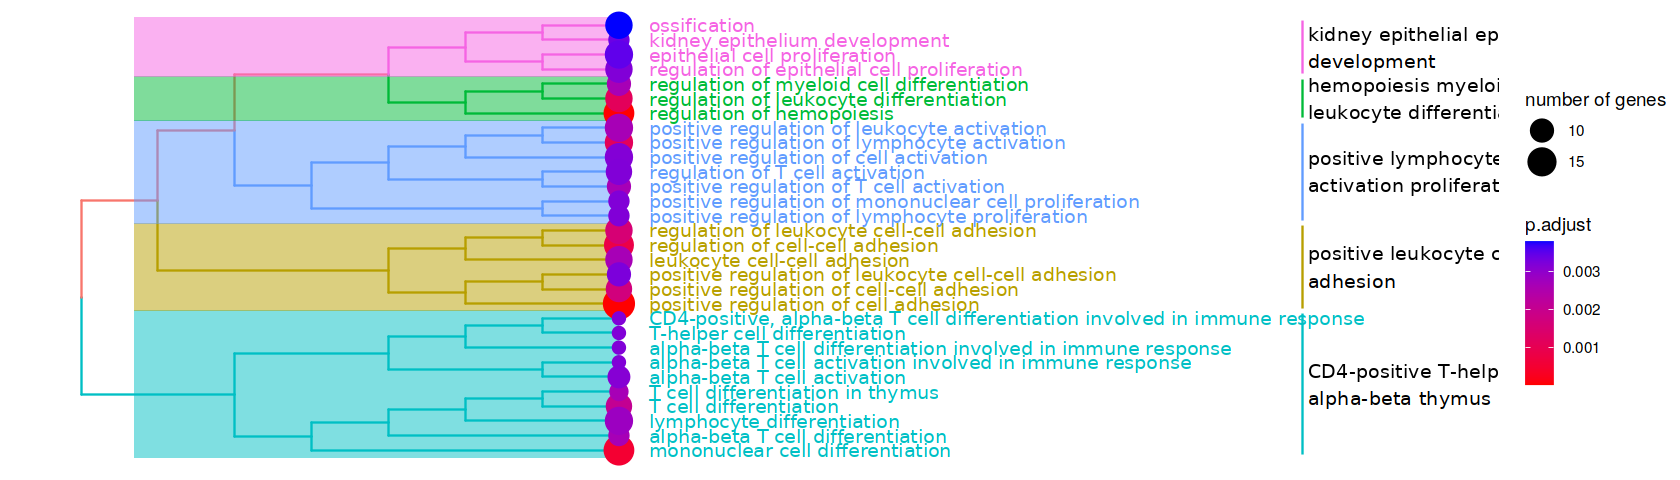

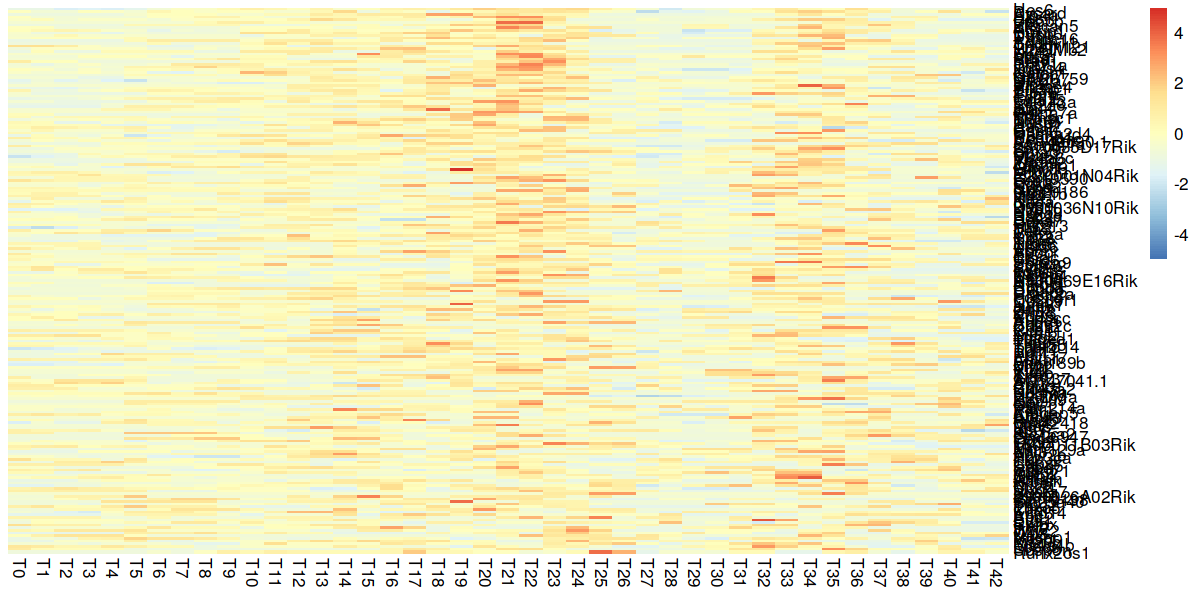

In [17]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)

